In [122]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import random
from sklearn.metrics import mean_squared_error
import datetime
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso
import statsmodels.formula.api as sm
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict, GridSearchCV
from sklearn import metrics
import xgboost as xgb
from xgboost import plot_importance
from sklearn.ensemble import RandomForestRegressor

In [96]:
qbs = pd.read_csv('C://Users//Michael//Desktop//Springboard//Capstone2//csvFiles//qbModelData.csv',index_col=0)

In [97]:
# Find index for fantasypoints (target variable) so we can break data into train/test easier
cols = list(qbs.columns)
for i in range(len(cols)):
    if cols[i] == 'FantasyPointsFanDuel':
        idx = i
        
cols.pop(idx)
cols
cols.append('FantasyPointsFanDuel')

# Sort by season, week. Use sorted DF to split into train/test so we can look at results for each week in test set
qbs = qbs[cols]
qbs = qbs.sort_values(['season','Week'])

In [98]:
# Wnat to use around 25% of our data as test
len(qbs)*.25

911.5

In [99]:
qbs.iloc[:-937,:-1]

,date,Opponent,gameId,Name,Team,season,Week,homeAway,surface,roof,...,defFantasyPointsAllowed7,defPYAallowed7,yardsMatchup,oTotMatchup,oPassMatchup,firstDownMatchup,passTdMatchup,passingRatingMatchup,fptsMatchup,PYAMatchup
13,2011-09-18,Bills,201109180buf,Jason Campbell,Raiders,2011,2,away,turf,outdoors,...,15.517143,7.742857,424.428571,3.912857,6.675714,35.857143,3.428571,204.570000,36.171429,15.600000
37,2011-09-18,49ers,201109180sfo,Tony Romo,Cowboys,2011,2,away,grass,outdoors,...,17.428571,7.157143,571.571429,3.008571,5.218571,41.571429,3.285714,176.518571,38.928571,15.085714
38,2011-09-18,Panthers,201109180car,Aaron Rodgers,Packers,2011,2,away,grass,outdoors,...,17.428571,7.157143,550.142857,11.350000,16.038571,41.142857,3.285714,176.518571,38.928571,15.085714
39,2011-09-18,Broncos,201109180den,Andy Dalton,Bengals,2011,2,away,grass,outdoors,...,17.428571,7.157143,520.428571,-2.594286,4.970000,40.000000,3.285714,176.518571,38.928571,15.085714
49,2011-09-18,Patriots,201109180nwe,Philip Rivers,Chargers,2011,2,away,turf,outdoors,...,15.388571,6.028571,466.142857,-0.360000,3.327143,41.142857,4.857143,200.104286,44.917143,16.000000
78,2011-09-18,Dolphins,201109180mia,Matt Schaub,Texans,2011,2,away,grass,outdoors,...,20.285714,8.100000,500.428571,14.651429,17.701429,40.142857,2.142857,184.841429,34.748571,14.700000
85,2011-09-18,Redskins,201109180was,Kevin Kolb,Cardinals,2011,2,away,grass,outdoors,...,23.731429,7.814286,507.571429,-0.881429,0.872857,42.428571,4.142857,202.524286,43.517143,15.985714
92,2011-09-19,Giants,201109190nyg,Sam Bradford,Rams,2011,2,away,turf,outdoors,...,18.225714,8.771429,435.142857,-2.330000,2.464286,36.000000,3.428571,201.155714,36.171429,16.528571
104,2011-09-18,Falcons,201109180atl,Michael Vick,Eagles,2011,2,away,turf,dome,...,16.557143,6.828571,496.000000,4.575714,2.611429,40.285714,2.714286,164.207143,31.468571,13.957143
111,2011-09-18,Vikings,201109180min,Josh Freeman,Buccaneers,2011,2,away,turf,dome,...,11.405714,5.500000,421.571429,3.518571,4.160000,39.428571,2.142857,150.952857,24.374286,11.985714


In [100]:
X_train = qbs.iloc[:-937,:-1]
X_test = qbs.iloc[-937:,:-1]
y_train = qbs.iloc[:-937,-1:]
y_test = qbs.iloc[-937:,-1:]

In [101]:
X_test.head()

,date,Opponent,gameId,Name,Team,season,Week,homeAway,surface,roof,...,defFantasyPointsAllowed7,defPYAallowed7,yardsMatchup,oTotMatchup,oPassMatchup,firstDownMatchup,passTdMatchup,passingRatingMatchup,fptsMatchup,PYAMatchup
1358,2017-09-17,Saints,201709170nor,Tom Brady,Patriots,2017,2,away,turf,dome,...,18.768571,7.542857,518.857143,19.321429,23.761429,44.714286,4.571429,205.528571,39.205714,14.885714
1373,2017-09-17,Chiefs,201709170kan,Carson Wentz,Eagles,2017,2,away,grass,outdoors,...,14.034286,7.085714,502.285714,4.430000,6.595714,38.285714,1.857143,149.474286,29.611429,12.771429
1416,2017-09-17,Falcons,201709170atl,Aaron Rodgers,Packers,2017,2,away,turf,dome,...,14.691429,6.628571,571.142857,15.000000,13.288571,47.714286,4.000000,201.841429,39.408571,15.085714
1434,2017-09-17,Broncos,201709170den,Dak Prescott,Cowboys,2017,2,away,grass,outdoors,...,13.608571,6.271429,415.857143,-3.750000,-4.668571,35.857143,3.000000,181.592857,32.065714,14.428571
1438,2017-09-14,Bengals,201709140cin,Deshaun Watson,Texans,2017,2,away,turf,outdoors,...,12.134286,5.828571,406.571429,-10.707143,-8.460000,35.285714,2.285714,161.271429,35.368571,13.014286


In [102]:
# Now we want to predict points for (pf) for the homeMatchup/awayMatchup tables
# Setup table in way to do so:
ID_col = ['gameId']
target_col = ['FantasyPointsFanDuel']
cat_cols = ['homeAway','roof','surface']
num_cols= ['avgPYA', 'avgPassingTouchdowns7','avgPassingRating7', 'avgPf', 'avgOvr_x', 'avgOff', 'avgPass', 'avgPblk', 
           'avgRecv', 'avgRun', 'avgRblk', 'totalDvoa_x', 'offDvoa', 'stDvoa', 'avgPa', 'avgOvr_y', 'avgDef', 'avgRdef',
           'avgPrsh', 'avgCov', 'totalDvoa_y', 'defDvoa', 'ptsMatchup', 'offMatchup', 'ovrMatchup', 'passMatchup', 
           'pblkMatchup', 'runMatchup', 'offDvoaMatchup','totalDvoaMatchup','spread','total','impliedTotal',
           'FantasyPointsPerGame7','totExpAvg', 'oTotAvg', 'oPassAvg', 'oRushAvg', 'oTovAvg', 'firstDownsAvg', 'netPydsAvg', 'totYdsAvg', 'toAvg',
           'passCompAvg', 'passAttAvg', 'passYdsAvg', 'passTdsAvg', 'intsAvg', 'timesSackedAvg', 'yardsLostOnSacksAvg',
           'totalSecondsAvg', 'lateDownConvAvg', 'lateDownAttAvg', 'defPassingYardsAllowed7', 'defOtotAllowed7', 'defOpassAllowed7', 
           'defFirstDownsAllowed7','defPassTdsAllowed7', 'defPassingRatingAllowed7', 'defFantasyPointsAllowed7', 'defPYAallowed7',
           'yardsMatchup', 'oTotMatchup', 'oPassMatchup', 'firstDownMatchup', 'passTdMatchup', 'passingRatingMatchup',
           'fptsMatchup','PYAMatchup']
other_col= ['date','Opponent','Name','Team','season','Week','PassingCompletions',
 'PassingAttempts', 'PassingCompletionPercentage', 'PassingYards', 'PassingYardsPerAttempt','PassingTouchdowns','PassingTouchdownsPerAttempt',
 'PassingInterceptions', 'PassingRating','RushingAttempts', 'RushingYards', 'RushingYardsPerAttempt', 'RushingTouchdowns','pf','result',
 'winLose','team','oTot', 'oPass', 'oRush', 'oTov', 'firstDowns', 'netPyds', 'totYds',
 'passTds', 'to', 'timesSacked', 'yardsLostOnSacks', 'fumbles', 'fumblesLost', 'totalSeconds', 'lateDownConv', 'lateDownAtt']

In [103]:
# Create label encoders for categorical variables and split the data set
# to train & test, further split the train data set to Train and Validate

#create label encoders for categorical features
for var in cat_cols:
    number = LabelEncoder()
    X_train[var] = number.fit_transform(X_train[var].astype('str'))

for var in cat_cols:
    number = LabelEncoder()
    X_test[var] = number.fit_transform(X_test[var].astype('str'))
    
# Pass the imputed and dummy (missing values flags) variables into the
# modeling process. 
features=list(set(list(X_train.columns))-set(ID_col)-set(target_col)-set(other_col))

X_train = X_train[list(features)]
X_test = X_test[list(features)]

# Now that categorical vars have been transformed, create new list of vars that contain all variables needed

allVars = cat_cols + num_cols

X_train = X_train[allVars]

X_test = X_test[allVars]

X_train.tail()

,homeAway,roof,surface,avgPYA,avgPassingTouchdowns7,avgPassingRating7,avgPf,avgOvr_x,avgOff,avgPass,...,defFantasyPointsAllowed7,defPYAallowed7,yardsMatchup,oTotMatchup,oPassMatchup,firstDownMatchup,passTdMatchup,passingRatingMatchup,fptsMatchup,PYAMatchup
13,0,1,1,7.857143,2.285714,105.225714,27.857143,67.600000,66.914286,64.557143,...,15.517143,7.742857,424.428571,3.912857,6.675714,35.857143,3.428571,204.570000,36.171429,15.600000
37,0,1,0,7.928571,2.142857,96.092857,27.000000,69.528571,70.171429,59.471429,...,17.428571,7.157143,571.571429,3.008571,5.218571,41.571429,3.285714,176.518571,38.928571,15.085714
38,0,1,0,7.928571,2.142857,96.092857,31.142857,75.957143,80.371429,81.900000,...,17.428571,7.157143,550.142857,11.350000,16.038571,41.142857,3.285714,176.518571,38.928571,15.085714
39,0,1,0,7.928571,2.142857,96.092857,19.142857,69.500000,72.157143,66.757143,...,17.428571,7.157143,520.428571,-2.594286,4.970000,40.000000,3.285714,176.518571,38.928571,15.085714
49,0,1,1,9.971429,3.285714,130.872857,27.285714,73.571429,75.828571,73.685714,...,15.388571,6.028571,466.142857,-0.360000,3.327143,41.142857,4.857143,200.104286,44.917143,16.000000


In [104]:
model = xgb.XGBRegressor(objective='reg:squarederror')
model.fit(X_train, y_train)

[07:34:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [105]:
# Perform 10-fold cross validation
scores = cross_val_score(model, X_train, y_train,scoring='neg_mean_squared_error', cv=10)
print('Cross-validated scores: ', scores)

[07:34:18] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:34:20] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:34:21] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:34:23] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:34:25] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:34:26] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:34:28] WARNI

In [106]:
y_pred = model.predict(X_test)
print(mean_squared_error(y_test, y_pred))

54.68081882639305


In [107]:
feats = X_train.columns
importances = model.feature_importances_
zipped = list(zip(feats,importances))

sortedFeats = sorted(zipped, key=lambda x: x[1],reverse=True)
halfVars = int(len(sortedFeats)/2)

listTopVars = []
for feat in sortedFeats[:halfVars]:
    listTopVars.append(feat[0])
    
# Now that we have picked the most important initial variables, let's redo the model and only include these variables

X_train = X_train[listTopVars]

X_test = X_test[listTopVars]

print("number of vars: " + str(halfVars))
print(listTopVars)

number of vars: 36
['FantasyPointsPerGame7', 'impliedTotal', 'avgRblk', 'total', 'fptsMatchup', 'ovrMatchup', 'intsAvg', 'avgRecv', 'totalDvoa_y', 'oPassAvg', 'pblkMatchup', 'firstDownsAvg', 'defOtotAllowed7', 'avgOff', 'passCompAvg', 'oPassMatchup', 'avgRun', 'yardsLostOnSacksAvg', 'avgCov', 'avgDef', 'defPassingRatingAllowed7', 'offDvoa', 'oTovAvg', 'passMatchup', 'totExpAvg', 'passTdsAvg', 'oRushAvg', 'ptsMatchup', 'oTotAvg', 'totalSecondsAvg', 'offDvoaMatchup', 'avgPrsh', 'avgPassingRating7', 'defFantasyPointsAllowed7', 'defOpassAllowed7', 'stDvoa']


In [108]:
model = xgb.XGBRegressor()
model.fit(X_train, y_train)

[07:34:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [109]:
y_pred = model.predict(X_test)
print(mean_squared_error(y_test, y_pred))

54.15586510666498


In [110]:
# run thru this process again and see if we can imporve further

feats = X_train.columns
importances = model.feature_importances_
zipped = list(zip(feats,importances))

sortedFeats = sorted(zipped, key=lambda x: x[1],reverse=True)
halfVars = int(len(sortedFeats)/2)

listTopVars = []
for feat in sortedFeats[:halfVars]:
    listTopVars.append(feat[0])
    
# Now that we have picked the most important initial variables, let's redo the model and only include these variables

X_train = X_train[listTopVars]

X_test = X_test[listTopVars]

model = xgb.XGBRegressor()
model.fit(X_train, y_train)

print("number of vars: " + str(halfVars))
print(listTopVars)
y_pred = model.predict(X_test)
print(mean_squared_error(y_test, y_pred))

[07:35:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
number of vars: 18
['FantasyPointsPerGame7', 'impliedTotal', 'total', 'avgDef', 'fptsMatchup', 'oPassAvg', 'oTotAvg', 'totExpAvg', 'firstDownsAvg', 'avgOff', 'avgCov', 'avgRun', 'avgRecv', 'intsAvg', 'ovrMatchup', 'pblkMatchup', 'oTovAvg', 'offDvoa']
54.093279032175325


In [116]:
# Use grid search to find optimal parameters for xgb

param_grid = {"n_estimators": [100,200,500],
            "max_depth": [3,5,7],
            "min_child_weight": [1,2,4,8]
             }

xgboost = xgb.XGBRegressor(objective='reg:squarederror')
xgb_cv = GridSearchCV(xgboost,param_grid,cv=5)
xgb_cv.fit(X_train,y_train.values.ravel())
xgb_cv.best_params_

{'max_depth': 3, 'min_child_weight': 4, 'n_estimators': 100}

In [120]:
# use these params in xgb model
modelXgb = xgb.XGBRegressor(n_estimators=100,max_depth=3,min_child_weight=4)
modelXgb.fit(X_train, y_train)
y_pred = modelXgb.predict(X_test)
print(mean_squared_error(y_test, y_pred))

[08:26:44] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
54.30052977889124


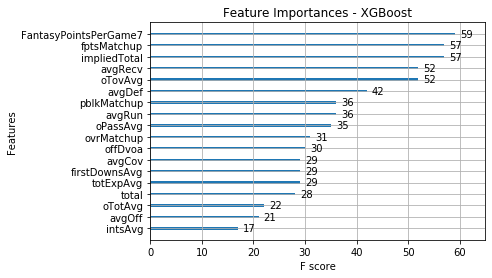

In [154]:
plot_importance(modelXgb)
plt.title("Feature Importances - XGBoost")
plt.show()

In [39]:
# Compare results to fantasyData predictions
# First, read in projections for needed seasons
qb_proj_2017 = pd.read_csv('C://Users//Michael//Desktop//Springboard//Capstone2//csvFiles//DFS_Data//QB//projections//QBproj2017.csv',index_col=0)
qb_proj_2018 = pd.read_csv('C://Users//Michael//Desktop//Springboard//Capstone2//csvFiles//DFS_Data//QB//projections//QBproj2018.csv',index_col=0)
qb_proj_2017['season'] = 2017
qb_proj_2018['season'] = 2018

#combine the two seasons
qb_proj = qb_proj_2017.append(qb_proj_2018)

# rename the FantasyPointsFanDuel column to FantasyDataProjection
qb_proj = qb_proj.rename(columns={'FantasyPointsFanDuel': 'FantasyDataProjection'})

# select only needed cols
qb_proj = qb_proj[['Name','Week','season','FantasyDataProjection']]
qb_proj.head()

,Name,Week,season,FantasyDataProjection
Rank,,,,
1,Tom Brady,2,2017,22.17
2,Tom Brady,5,2017,21.87
3,Aaron Rodgers,2,2017,21.66
4,Tom Brady,12,2017,21.46
5,Aaron Rodgers,5,2017,20.98


In [61]:
X_train = qbs.iloc[:-937,:-1]
X_test = qbs.iloc[-937:,:-1]
y_train = qbs.iloc[:-937,-1:]
y_test = qbs.iloc[-937:,-1:]

X_test = X_test.merge(qb_proj,on=['Name','Week','season'])
X_test.head()

,date,Opponent,gameId,Name,Team,season,Week,homeAway,surface,roof,...,defPYAallowed7,yardsMatchup,oTotMatchup,oPassMatchup,firstDownMatchup,passTdMatchup,passingRatingMatchup,fptsMatchup,PYAMatchup,FantasyDataProjection
0,2017-09-17,Saints,201709170nor,Tom Brady,Patriots,2017,2,away,turf,dome,...,7.542857,518.857143,19.321429,23.761429,44.714286,4.571429,205.528571,39.205714,14.885714,22.17
1,2017-09-17,Chiefs,201709170kan,Carson Wentz,Eagles,2017,2,away,grass,outdoors,...,7.085714,502.285714,4.430000,6.595714,38.285714,1.857143,149.474286,29.611429,12.771429,15.09
2,2017-09-17,Falcons,201709170atl,Aaron Rodgers,Packers,2017,2,away,turf,dome,...,6.628571,571.142857,15.000000,13.288571,47.714286,4.000000,201.841429,39.408571,15.085714,21.66
3,2017-09-17,Broncos,201709170den,Dak Prescott,Cowboys,2017,2,away,grass,outdoors,...,6.271429,415.857143,-3.750000,-4.668571,35.857143,3.000000,181.592857,32.065714,14.428571,15.04
4,2017-09-14,Bengals,201709140cin,Deshaun Watson,Texans,2017,2,away,turf,outdoors,...,5.828571,406.571429,-10.707143,-8.460000,35.285714,2.285714,161.271429,35.368571,13.014286,12.36


In [62]:
#test how FantasyData's projections did
print(mean_squared_error(y_test, X_test['FantasyDataProjection']))

56.455929348986125


Our MSE for the XGB model was 54.301. FantasyData's MSE was 56.46. Our first model outperforms FantasyData's projection system.

In [125]:
# Now try random forest regressor
X_train = qbs.iloc[:-937,:-1]
X_test = qbs.iloc[-937:,:-1]
y_train = qbs.iloc[:-937,-1:]
y_test = qbs.iloc[-937:,-1:]

# Create label encoders for categorical variables and split the data set
# to train & test, further split the train data set to Train and Validate

#create label encoders for categorical features
for var in cat_cols:
    number = LabelEncoder()
    X_train[var] = number.fit_transform(X_train[var].astype('str'))

for var in cat_cols:
    number = LabelEncoder()
    X_test[var] = number.fit_transform(X_test[var].astype('str'))
    
# Pass the imputed and dummy (missing values flags) variables into the
# modeling process. 
features=list(set(list(X_train.columns))-set(ID_col)-set(target_col)-set(other_col))

X_train = X_train[list(features)]
X_test = X_test[list(features)]

# Now that categorical vars have been transformed, create new list of vars that contain all variables needed

allVars = cat_cols + num_cols

X_train = X_train[allVars]

X_test = X_test[allVars]



# model2 = RandomForestRegressor()
# model2.fit(X_train, y_train)

In [128]:
# Use grid search to find optimal parameters

param_grid = {"n_estimators": [1,10,100,1000],
            "max_features": ["auto", "sqrt", "log2"],
            "min_samples_split": [2,4,8],
            "bootstrap": [True, False],
             }
rf = RandomForestRegressor(max_features='sqrt',min_samples_split=2)
rf_cv = GridSearchCV(rf,param_grid,cv=5)
rf_cv.fit(X_train,y_train.values.ravel())
rf_cv.best_params_

KeyboardInterrupt: 

In [129]:
#put optimal params from grid search into model

model2 = RandomForestRegressor(n_estimators=1000,max_features='sqrt',min_samples_split=2,bootstrap=True)
model2.fit(X_train, y_train)
y_pred = model2.predict(X_test)
print(mean_squared_error(y_test, y_pred))

C:\Python37\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


53.22361844730973


Using grid search to tune our random forest regressor, we get a model that outperforms XGB, as the MSE for this model is 53.224

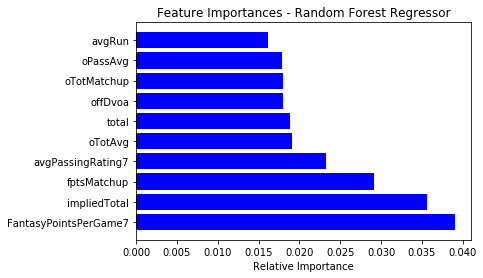

In [158]:
features = X_train.columns
importances = model2.feature_importances_
indices = np.argsort(importances)[::-1]
plt.title('Feature Importances - Random Forest Regressor')
plt.barh(range(len(indices[:10])), importances[indices[:10]], color='b', align='center')
plt.yticks(range(len(indices[:10])), [features[i] for i in indices[:10]])
plt.xlabel('Relative Importance')
plt.show()

In [159]:
# Next, build a lasso model

lasso = Lasso()
lasso.fit(X_train,y_train)
train_score=lasso.score(X_train,y_train)
test_score=lasso.score(X_test,y_test)
coeff_used = np.sum(lasso.coef_!=0)
print("training score:", train_score) 
print("test score: ", test_score)
print("number of features used: ", coeff_used)
lasso001 = Lasso(alpha=0.01, max_iter=10e5)
lasso001.fit(X_train,y_train)
train_score001=lasso001.score(X_train,y_train)
test_score001=lasso001.score(X_test,y_test)
coeff_used001 = np.sum(lasso001.coef_!=0)
print("training score for alpha = 0.01:", train_score001) 
print("test score for alpha = 0.01: ", test_score001)
print("number of features used: for alpha = 0.01:", coeff_used001)
lasso00001 = Lasso(alpha=0.0001, max_iter=10e5)
lasso00001.fit(X_train,y_train)
train_score00001=lasso00001.score(X_train,y_train)
test_score00001=lasso00001.score(X_test,y_test)
coeff_used00001 = np.sum(lasso00001.coef_!=0)
print("training score for alpha = 0.0001:", train_score00001) 
print("test score for alpha = 0.0001: ", test_score00001)
print("number of features used: for alpha = 0.0001:", coeff_used00001)

training score: 0.15177345949366738
test score:  0.11642935668394626
number of features used:  13
training score for alpha = 0.01: 0.17674426691367462
test score for alpha = 0.01:  0.12181880760767339
number of features used: for alpha = 0.01: 48
training score for alpha = 0.0001: 0.17739371455575814
test score for alpha = 0.0001:  0.1167957954591019
number of features used: for alpha = 0.0001: 56


C:\Python37\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6365.794780474738, tolerance: 14.897672858678481
  positive)


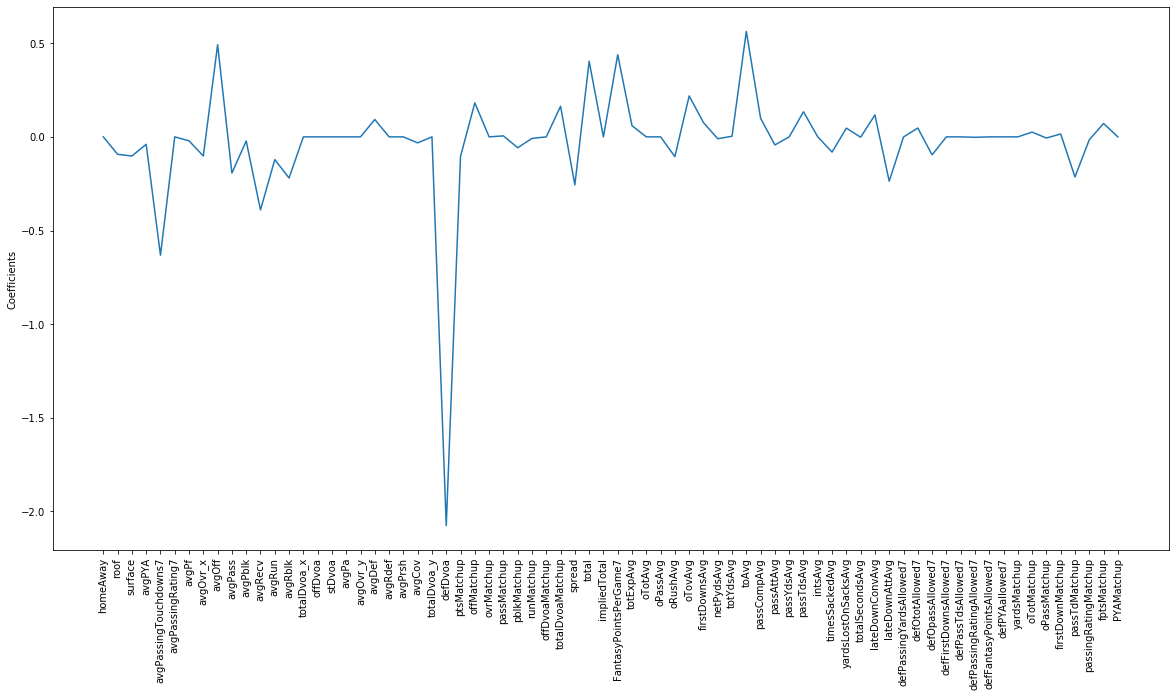

In [160]:
lasso = Lasso(alpha=0.01)
lasso_coef = lasso.fit(X_train,y_train).coef_

plt.figure(figsize=(20,10))
_ = plt.plot(range(len(X_train.columns)),lasso_coef)
_ = plt.xticks(range(len(X_train.columns)),X_train.columns, rotation=90)
_ = plt.ylabel('Coefficients')

plt.show()

Text(0.5, 1.0, 'Feature Importances - Lasso Regression')

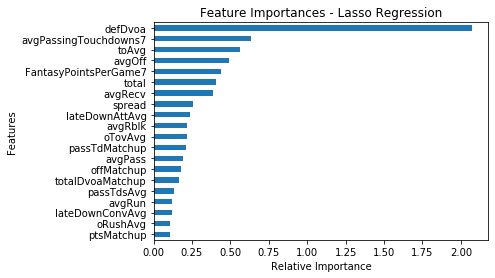

In [169]:
lasso_coef = pd.Series(lasso_coef, index=X_train.columns)
imp_coef = np.abs(lasso_coef).sort_values()[-20:]
imp_coef.plot(kind='barh')
plt.ylabel('Features')
plt.xlabel('Relative Importance')
plt.title('Feature Importances - Lasso Regression')

In [93]:
# List variables that are used in the Lasso Model
X_train.columns[lasso.coef_!=0]

Index(['roof', 'surface', 'avgPYA', 'avgPassingTouchdowns7', 'avgPf',
       'avgOvr_x', 'avgOff', 'avgPass', 'avgPblk', 'avgRecv', 'avgRun',
       'avgRblk', 'avgDef', 'avgCov', 'defDvoa', 'ptsMatchup', 'offMatchup',
       'passMatchup', 'pblkMatchup', 'runMatchup', 'totalDvoaMatchup',
       'spread', 'total', 'impliedTotal', 'FantasyPointsPerGame7', 'totExpAvg',
       'oRushAvg', 'oTovAvg', 'firstDownsAvg', 'netPydsAvg', 'totYdsAvg',
       'toAvg', 'passCompAvg', 'passAttAvg', 'passTdsAvg', 'timesSackedAvg',
       'yardsLostOnSacksAvg', 'totalSecondsAvg', 'lateDownConvAvg',
       'lateDownAttAvg', 'defPassingYardsAllowed7', 'defOtotAllowed7',
       'defOpassAllowed7', 'defPassingRatingAllowed7', 'yardsMatchup',
       'oTotMatchup', 'oPassMatchup', 'firstDownMatchup', 'passTdMatchup',
       'passingRatingMatchup', 'fptsMatchup'],
      dtype='object')

In [94]:
lasso.fit(X_train,y_train)
y_pred = lasso.predict(X_test)
print(mean_squared_error(y_test, y_pred))

51.29570054964321


C:\Python37\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6365.794780474738, tolerance: 14.897672858678481
  positive)


When using Lasso regression with $\alpha = 0.01$, we get our best model yet, with $MSE = 51.296$